### Hibernation
This notebook looks into which fume hoods haven't beed used in a while, which can indicate the ability to be hibernated

In [44]:
import sys
sys.path.append('../query')
from query_biotech import fume_query, query_to_list
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
from dateutil import tz
import requests
import json
import matplotlib.pyplot as plt
import math
import scipy.stats as st

from dateutil import parser
import matplotlib.dates as mdates

points = pd.read_csv("../biotech_point_names.csv")

<Response [200]>
<Response [200]>


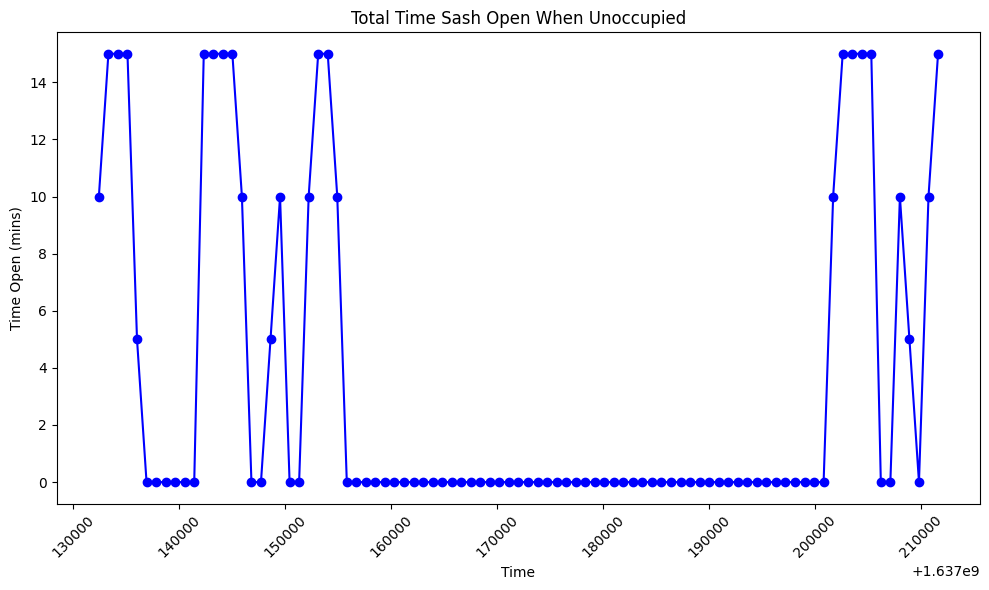

In [45]:
def total_time_sash_open(sash_point, occ_point, server, start, end, is_occupied):
  sash_list = query_to_list(sash_point, server, start, end)
  occ_list = query_to_list(occ_point, server, start, end)

  df = pd.concat([sash_list, occ_list], axis=1)
  df.columns = ["sash", "occ"]

  time_interval = df.index[1].minute - df.index[0].minute

  df["time_open_mins"] = np.where((df["sash"] > 1.2), time_interval, 0)

  df = df.dropna()
  df.index = df.index.map(lambda x: x.to_pydatetime().replace(tzinfo=tz.tzutc()).astimezone(tz.tzlocal()))

  df = df[df['occ'] == int(is_occupied)]

  df = df.groupby(pd.Grouper(freq='15Min', label='right')).sum()
  df.index = df.index.map(lambda x: x.to_pydatetime().timestamp())

  return df["time_open_mins"]

time_open_mins = total_time_sash_open(sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash",
                                occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
                                server="biotech_main",
                                start = str(datetime(2021, 11, 17, 1)),
                                end = str(datetime(2021, 11, 17, 2)),
                                is_occupied=0)

# plot the data
plt.figure(figsize=(10, 6)) # adjust if needed
plt.plot(time_open_mins.index, time_open_mins.values, marker='o', linestyle='-', color='b')
plt.title("Total Time Sash Open When Unoccupied")
plt.xlabel("Time")
plt.ylabel("Time Open (mins)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
def coldorhot(cfm, external, internal, time_interval):
    if external<=internal:
        #sensible heating equation
        return 1.08 * cfm * (internal - external) / (60 / time_interval)
    if external>internal:
        #enthalpy of air
        return 0.24 * cfm /13.333 * 60 * (external - internal) / (60 / time_interval)

def total_energy(cfm_point, sash_point, occ_point, internal_temp_point, external_temp_point, server, start, end):
    #external_temp_master = outside_temp(start,end)
    cfm_list = query_to_list(cfm_point, server, start, end)
    sash_list = query_to_list(sash_point, server, start, end)
    occ_list = query_to_list(occ_point, server, start, end)
    internal_temp_list = query_to_list(internal_temp_point, server, start, end)
    external_temp_list = query_to_list(external_temp_point, server, start, end)

    df = pd.concat([cfm_list, sash_list, occ_list, internal_temp_list, external_temp_list], axis=1)
    df.columns = ["cfm", "sash", "occ", "internal_temp", "external_temp"]
    #display(df)

    df["external_temp"] = df["external_temp"].interpolate()
    #display(df)

    time_interval = df.index[1].minute - df.index[0].minute

    df['BTU'] = df.apply(lambda df: coldorhot(df['cfm'], df['external_temp'], df['internal_temp'], time_interval=time_interval), axis=1)
    #print("\nFinal Data Frame: ")
    #display(df)

    df = df.groupby(pd.Grouper(freq='60Min', label='right')).sum()
    #display(df)

    return df["BTU"]

total_energy(cfm_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hoodvalve_flow/trend_log",
             sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash",
             occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
             internal_temp_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log",
             external_temp_point="#biotech/ground_flr_mech/building_hydronic_heating_syatems/reheat_heat_exchanger/oat",
             server = "biotech_main",
             start=str(datetime(2021, 11,17)),
             end=str(datetime(2021, 11, 18)))

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


2021-11-17 06:00:00    8897.68611
2021-11-17 07:00:00    8894.77461
2021-11-17 08:00:00    8835.30861
2021-11-17 09:00:00    8783.13078
2021-11-17 10:00:00    8987.19759
2021-11-17 11:00:00    8544.53253
2021-11-17 12:00:00    8110.01574
2021-11-17 13:00:00    8001.60912
2021-11-17 14:00:00    7649.42160
2021-11-17 15:00:00    7317.14085
2021-11-17 16:00:00    7134.71613
2021-11-17 17:00:00    6813.28503
2021-11-17 18:00:00    6341.22387
2021-11-17 19:00:00    6029.75880
2021-11-17 20:00:00    5692.98126
2021-11-17 21:00:00    7604.98143
2021-11-17 22:00:00    7453.21290
2021-11-17 23:00:00    7449.60969
2021-11-18 00:00:00    7380.94521
2021-11-18 01:00:00    7247.46801
2021-11-18 02:00:00    5845.40184
2021-11-18 03:00:00    5097.14043
2021-11-18 04:00:00    5082.45864
2021-11-18 05:00:00    5084.66550
2021-11-18 06:00:00    4933.91175
2021-11-18 07:00:00    4769.72898
2021-11-18 08:00:00    4646.37774
2021-11-18 09:00:00    4172.63094
2021-11-18 10:00:00    3894.46179
2021-11-18 11:

In [47]:
sash_point = points["Sash"][0]
server  = points["Server"][0]
time_start_22 = str(datetime(2022, 1,1))
time_end_22 = str(datetime(2022, 12,31))
time_start_23 = str(datetime(2023, 1,1))
time_end_23 = str(datetime(2023, 12,31))
sash_points = points["Sash"]


# def has_been_closed(sash_point,server,start,end):
#     query = fume_query(sash_point,server,start,end)
#     inches = [i[0] for i in query]
#     ratio = inches.count(min(inches))/len(inches)
#     return(ratio)

#ratio_list = [has_been_closed(sash_points[i], server,time_start,time_end) for i in range(len(sash_points))]
#print(ratio_list)

In [48]:
def sash_mean_sd(sash,server,start,end):
    query = fume_query(sash,server,start,end)
    return [np.std(query["value"]), np.mean(query["value"])]

big_list_22 = [sash_mean_sd(sash_points[i], server,time_start_22,time_end_22) for i in range(len(sash_points))]
big_list_23 = [sash_mean_sd(sash_points[i], server,time_start_23,time_end_23) for i in range(len(sash_points))]


<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

In [49]:
#big_list

sd_list_22 = [i[0] for i in big_list_22]
mean_list_22 = [i[1] for i in big_list_22]
data_22 = {"Name":points["Lab"], "Mean": mean_list_22, "Stdev":sd_list_22}
ndf_22 = pd.DataFrame(data_22)
display(ndf_22)

sd_list_23 = [i[0] for i in big_list_23]
mean_list_23 = [i[1] for i in big_list_23]
data_23 = {"Name":points["Lab"], "Mean": mean_list_23, "Stdev":sd_list_23}
ndf_23 = pd.DataFrame(data_23)
display(ndf_23)

,Name,Mean,Stdev
0,G54,6.062909,3.964492
1,141,3.069894,0.886199
2,143,3.203824,1.209632
3,147B,4.046700,1.972438
4,153,3.127982,1.504905
...,...,...,...
61,445B,1.476354,1.198112
62,453,4.297896,2.337480
63,453B,3.343178,1.717709
64,457,2.448833,2.064139


,Name,Mean,Stdev
0,G54,4.776038,3.349676
1,141,2.716624,0.785817
2,143,3.255679,1.091862
3,147B,3.382482,1.845316
4,153,2.790709,1.502080
...,...,...,...
61,445B,0.038446,0.331155
62,453,3.798430,1.838187
63,453B,2.970598,1.882874
64,457,1.664381,1.310066


In [50]:
ndf_sorted_mean_22 = ndf_22.sort_values(by="Mean", ascending=False)
fig = px.bar(ndf_sorted_mean_22, x = "Name", y = "Mean",title="Mean Sash Heights Across Labs 2022")
#fig.write_image("C:\\Users\\Rob\\Desktop\\ESW\\Fume\\energy_across_labs.png",scale=4)
fig.show()

ndf_sorted_mean_23 = ndf_23.sort_values(by="Mean", ascending=False)
fig = px.bar(ndf_sorted_mean_23, x = "Name", y = "Mean",title="Mean Sash Heights Across Labs 2023")
#fig.write_image("C:\\Users\\Rob\\Desktop\\ESW\\Fume\\energy_across_labs.png",scale=4)
fig.show()

In [51]:
ndf_sorted_stdev_22 = ndf_22.sort_values(by="Stdev", ascending=False)
fig = px.bar(ndf_sorted_stdev_22, x = "Name", y = "Stdev",title="Standard Deviation of Sash Heights Across Labs 2022")
#fig.write_image("C:\\Users\\Rob\\Desktop\\ESW\\Fume\\energy_across_labs.png",scale=4)
fig.show()

ndf_sorted_stdev_23 = ndf_23.sort_values(by="Stdev", ascending=False)
fig = px.bar(ndf_sorted_stdev_23, x = "Name", y = "Stdev",title="Standard Deviation of Sash Heights Across Labs 2023")
#fig.write_image("C:\\Users\\Rob\\Desktop\\ESW\\Fume\\energy_across_labs.png",scale=4)
fig.show()

In [52]:
ndf_22["Candidate for Hibernation"] = np.where((ndf_22["Stdev"]<0.25)&(ndf_22["Mean"]<0.5), True,False)
ndf_23["Candidate for Hibernation"] = np.where((ndf_23["Stdev"]<0.25)&(ndf_23["Mean"]<0.5), True,False)

In [53]:
display(ndf_22)
display(ndf_23)

,Name,Mean,Stdev,Candidate for Hibernation
0,G54,6.062909,3.964492,False
1,141,3.069894,0.886199,False
2,143,3.203824,1.209632,False
3,147B,4.046700,1.972438,False
4,153,3.127982,1.504905,False
...,...,...,...,...
61,445B,1.476354,1.198112,False
62,453,4.297896,2.337480,False
63,453B,3.343178,1.717709,False
64,457,2.448833,2.064139,False


,Name,Mean,Stdev,Candidate for Hibernation
0,G54,4.776038,3.349676,False
1,141,2.716624,0.785817,False
2,143,3.255679,1.091862,False
3,147B,3.382482,1.845316,False
4,153,2.790709,1.502080,False
...,...,...,...,...
61,445B,0.038446,0.331155,False
62,453,3.798430,1.838187,False
63,453B,2.970598,1.882874,False
64,457,1.664381,1.310066,False
